# Contenuti
- [Import](#Import)
- [Dataset casuale](#Dataset-casuale)
- [Esempio con scikit-learn](#Esempio-con-scikit-learn)
- [Implementazione K-means](#Implementazione-K-means)
    - [Selezione casuale dei centroidi iniziali](#Selezione-casuale-dei-centroidi-iniziali)
    - [Assegnazione dei pattern](#Assegnazione-dei-pattern)
    - [Aggiornamento dei centroidi](#Aggiornamento-dei-centroidi)
    - [K-means](#K-means)
    - [Esecuzione](#Esecuzione)
- [Trovare il numero di profumi presenti](#Trovare-il-numero-di-profumi-presenti)
    - [Dataset](#Dataset)
    - [Esercizio](#Esercizio)

# Esercitazione 6
Nell'esercitazione odierna si implementerà l'algoritmo *K-means*. Verrà chiesto di implementarne le parti fondamentali, verificarne il corretto funzionamento e infine di utilizzare l'algoritmo sviluppato per risolvere un problema di clustering.

# Import
Per prima cosa è necessario eseguire l'import delle librerie utilizzate durante l'esecitazione.

In [2]:
%matplotlib inline
########
# Nota: se appare un warning relativo a un memory leak su Windows,
# decommentare le seguenti 2 righe di codice:
#import os
#os.environ['OMP_NUM_THREADS'] = '2'
########

import numpy as np
import matplotlib.pyplot as plt
import random

import ml_utilities
import ml_visualization

# Dataset casuale
Durante la fase di implementazione del *K-means* verrà utilizzato un dataset di esempio generato casualmente per poter verificare in maniera semplice il corretto funzionamento dell'algoritmo.

Scikit-learn mette a disposizione la funzione [**make_blobs(...)**](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) per generare raggruppamenti di punti con distribuzione gaussiana. Variando i parametri *n_samples* (numero totale di punti generati), *centers* (numero di raggruppamenti) e *random_state* (seme iniziale per la generazione casuale) è possibile ottenere dataset differenti.

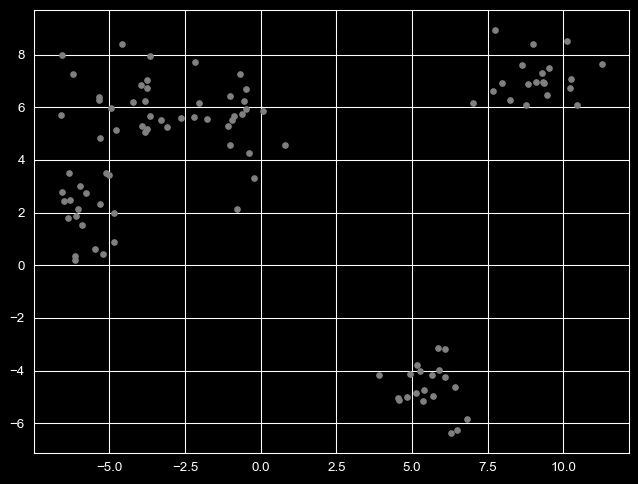

In [3]:
# Generazione di un dataset casuale
from sklearn.datasets import make_blobs

data, _ = make_blobs(n_samples=100, centers=5, random_state=1234)

plt.figure(num=0, dpi=96, figsize=(8, 6))
plt.scatter(data[:,0], data[:,1], c='grey', marker='o', s=16)
plt.show()

# Esempio con scikit-learn
La libreria Scikit-learn fornisce un'implementazione dei più importanti algoritmi di clustering. Per maggiori informazioni si rimanda alla [documentazione ufficiale](https://scikit-learn.org/stable/modules/clustering.html).

Di seguito un esempio di come utilizzare l'algoritmo *K-means* di Scikit-learn sul dataset appena generato.

/Users/samueleferri/Documents/Università/Magistrale/Machine Learning/Lab/MachineLearning/6 - KMeans/ml_visualization.py:119: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  plt.scatter(patterns[:, 0], patterns[:, 1],s=patternSize, c = patternColor,marker=marker, facecolor = '#000000')


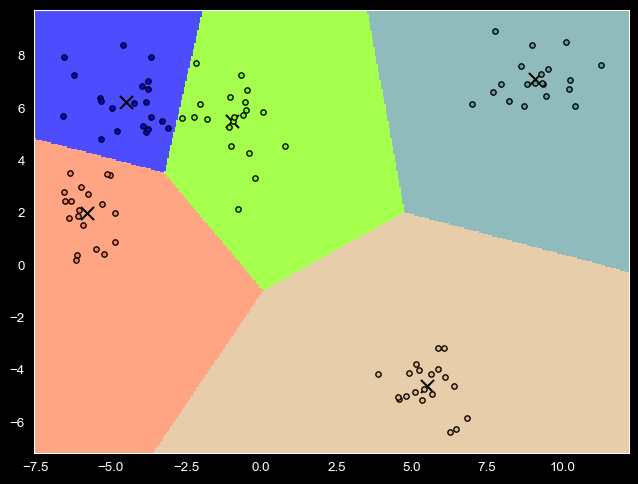

In [4]:
# Import della libreria
from sklearn.cluster import KMeans

# Definizione del numero di cluster attesi
n_clusters = 5

# Creazione dell'istanza di KMeans e addestramento
kmeans = KMeans(n_clusters=n_clusters, random_state=1234, n_init=1)
kmeans.fit(data)

# Visualizzazione dei risultati
plt.figure(num=0, dpi=96, figsize=(8, 6))
ml_visualization.draw_clustering_decision_boundaries(data, kmeans.labels_, kmeans.cluster_centers_, step=0.05)
plt.show()

È possibile ottenere i centroidi dei vari cluster utilizzando l'attributo **cluster\_centers\_** come mostrato nell'esempio seguente:

In [5]:
print('Centroidi ottenuti:\n', kmeans.cluster_centers_)

Centroidi ottenuti:
 [[-4.50296061  6.22703212]
 [ 5.51366983 -4.64045731]
 [ 9.11338955  7.10348958]
 [-0.95820208  5.50422472]
 [-5.7920073   1.9979973 ]]


Come per i classificatori, in Scikit-learn gli algoritmi di clustering mettono a disposizione il metodo **.predict(...)** che permette di ottenere l'indice del cluster a cui un pattern viene assegnato.

In [6]:
# Esempio di uso della funzione predict
print('Cluster predetti:\n', kmeans.predict([[-2.5, 0.0], [2.5, -4.0], [0.0, 5.0]]))

Cluster predetti:
 [4 1 3]


# Implementazione K-means
Per poter sviluppare la nostra versione dell'algoritmo si dovranno implementare le seguenti funzioni:
- **assign_patterns_to_clusters(...)** che restituisca un vettore contenente l’indice del cluster a cui è stato assegnato ogni pattern del dataset.
- **compute_centroids(...)** che dovrà restituire i nuovi centroidi calcolati come media dei pattern appartenenti ad ogni cluster.

Queste funzioni verranno successivamente richiamate all'interno della funzione **kmeans_execution(...)** che implementa l'intero *K-means*.

## Selezione casuale dei centroidi iniziali
Il primo passo del *K-means* richiede che vengano scelti casualmente $s$ (numero di cluster) pattern da utilizzare come centroidi iniziali.

La funzione **select_random_centroids(...)** restituisce $s$ centroidi scelti casualmente dai pattern di *data*. Sia il parametro *data* che il valore di ritorno sono **ndarray** bidimensionali in cui i pattern sono memorizzati per riga.

Nota: il parametro *seed* viene utilizzato per l’inizializzazione del generatore di numeri casuali. Per ulteriori dettagli si faccia riferimento alla documentazione della libreria [**random**](https://docs.python.org/3.6/library/random.html). A parità di *seed* il risultato della funzione non cambia in esecuzioni successive. La funzione **random.sample(...)** permette di selezionare un sottoinsieme di elementi da una lista (risolve il problema di selezionare più volte lo stesso elemento).

In [7]:
# La funzione restituisce s centroidi scelti casualmente tra i pattern di data

# data: ndarray bidimensionale in cui i pattern sono memorizzati per riga. Shape = (n_patterns, 2)
# s: numero intero, indica il numero di centroidi da selezionare
# seed: numero intero, utilizzato per inizializzare il generatore di numeri casuali

# Risultato: ndarray bidimensionale in cui i centroidi sono memorizzati per riga. Shape = (s, 2)

def select_random_centroids(data, s, seed):
    random.seed(seed)
    centroid_indices = random.sample(range(data.shape[0]), s)
    return data[centroid_indices]

## Assegnazione dei pattern
Ad ogni iterazione i pattern del dataset devono essere assegnati al cluster per cui è minima la distanza dal corrispondente centroide.

Si implementi la funzione **assign_patterns_to_clusters(...)** che restituisca un **ndarray** monodimensionale (*labels*) contenente l’indice del cluster a cui è stato assegnato ogni pattern. Per individuare il centroide più vicino ad ogni pattern è possibile utilizzare la funzione **compute_square_euclidean_distance(...)** già disponibile nella libreria ml_utilities.

Inoltre si dovrà calcolare e restituire la somma dei quadrati delle distanze di tutti i pattern $\boldsymbol{x}$ dai centroidi a cui sono stati assegnati (*sum_square_distances*), indicata con $J_e$:

$\Large{J_e = \sum_{i=1...s} \sum_{\boldsymbol{x} \in C_i} \lVert \boldsymbol{x} - \boldsymbol{\overline{x}_i} \rVert^2}$

$\Large{\boldsymbol{\overline{x}_i} = \frac{1}{n_i} \sum_{\boldsymbol{x} \in C_i} \boldsymbol{x}}$

dove $C_i$ è l'i-esimo cluster, $n_i$ il numero di pattern che contiene e $\boldsymbol{\overline{x}_i}$ il suo centroide (media).

In [8]:
# Esercizio 1: si completi il codice della funzione assign_patterns_to_clusters
# La funzione deve restituire un vettore contenente l'indice del cluster a cui
# è stato assegnato ogni pattern

# data: ndarray bidimensionale in cui i pattern sono memorizzati per riga. Shape = (n_patterns, 2)
# centroids: ndarray bidimensionale in cui i centroidi sono memorizzati per riga. Shape = (s, 2)

# Risultato 1: ndarray monodimensionale in cui sono memorizzate le etichette dei pattern. Shape = (n_patterns,)
# Risultato 2: valore numerico, somma dei quadrati delle distanze dei pattern dai centroidi a cui sono assegnati
# ml_utilities.compute_square_euclidean_distance(data[i], centroids[j])

def assign_patterns_to_clusters(data, centroids):
    data_count = data.shape[0]
    centroid_count = centroids.shape[0]
    distances = np.empty((data_count, centroid_count))

    for i in range(data_count):
        for j in range(centroid_count):
            distances[i, j] = ml_utilities.compute_square_euclidean_distance(data[i], centroids[j])

    labels = np.argmin(distances, axis=1) #(data_count, )
    sum_square_distances = np.min(distances, axis=1).sum()
    return labels, sum_square_distances

In [9]:
centroids = select_random_centroids(data = data, s = 5, seed = 42)
labels, je = assign_patterns_to_clusters(data, centroids)
print(je)

1939.8176977861099


## Aggiornamento dei centroidi
Una volta assegnati i pattern ai rispettivi cluster è necessario calcolare i nuovi centroidi come media dei pattern appartenenti ad ogni cluster.

Si implementi la funzione **compute_centroids(...)** in modo tale che questa restituisca un **ndarray** bidimensionale (*centroids*) contenente i nuovi centroidi (memorizzati per riga).

In [10]:
# Esercizio 2: si completi il codice della funzione compute_centroids
# La funzione deve restituire i nuovi centroidi calcolati come media
# dei pattern appartenenti ad ogni cluster

# data: ndarray bidimensionale in cui i pattern sono memorizzati per riga. Shape = (n_patterns, 2)
# labels: ndarray monodimensionale in cui sono memorizzate le etichette dei pattern. Shape = (n_patterns,)
# s: numero intero, indica il numero di centroidi da selezionare

# Risultato: ndarray bidimensionale in cui i centroidi sono memorizzati per riga. Shape = (s, 2)

def compute_centroids(data, labels, s):
    data_count = data.shape[0]
    centroids = np.zeros((s, data.shape[1]))
    count = np.zeros(s)

    for i in range(data_count):
        label = labels[i]
        centroids[label] += data[i]
        count[label] += 1

    for i in range(s):
        if count[i] > 0:
            centroids[i] /= count[i]

    return centroids

In [11]:
centroids = select_random_centroids(data = data, s = 5, seed = 42)
labels, je = assign_patterns_to_clusters(data, centroids)
new_centroids = compute_centroids(data, labels, s = 5)
print(new_centroids)

[[ 5.51366983 -4.64045731]
 [-1.25780313  6.09956461]
 [-5.7920073   1.9979973 ]
 [ 6.95049974  6.41386083]
 [-4.50296061  6.22703212]]


## K-means
Le parti appena implementate costituiscono i blocchi fondamentali su cui si basa l'algoritmo *K-means*. La cella seguente definisce la funzione **kmeans_execution(...)** che, utilizzando le funzioni appena sviluppate, esegue l'algoritmo restituendo:

- l'indice del cluster a cui è stato assegnato ogni pattern di input (*labels*);
- la lista dei centroidi di ogni cluster (*centroids*);
- la somma dei quadrati delle distanze (*sum_square_distances*);
- il numero di iterazioni eseguite (*iteration_count*).

In [12]:
def kmeans_execution(data, s, max_iteration_count, seed):
    centroids = select_random_centroids(data, s, seed)
    iteration_count = 0
    modified = True
    while modified and iteration_count < max_iteration_count:
        labels, sum_square_distances = assign_patterns_to_clusters(data, centroids)
        new_centroids = compute_centroids(data, labels, s)
        modified = not np.array_equal(centroids, new_centroids)
        centroids = new_centroids
        iteration_count += 1

    return labels, centroids, sum_square_distances, iteration_count

## Esecuzione
Il codice contenuto nella cella seguente richiama la funzione **kmeans_execution(...)** sul dataset generato in precedenza e ne visualizza i risultati.

Si verifichi il funzionamento dell’algoritmo al variare del numero di cluster ($s$), del seme per la scelta casuale dei centroidi iniziali (*seed*) e del massimo numero di iterazioni consentite (*max_iteration_count*).

Somma quadrati distanze: 174.131
Numero di iterazioni: 3


/Users/samueleferri/Documents/Università/Magistrale/Machine Learning/Lab/MachineLearning/6 - KMeans/ml_visualization.py:119: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  plt.scatter(patterns[:, 0], patterns[:, 1],s=patternSize, c = patternColor,marker=marker, facecolor = '#000000')


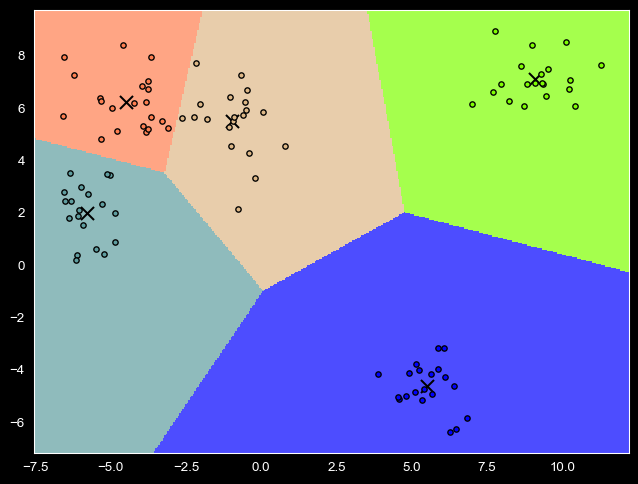

In [13]:
s = 5
seed = 42
max_iteration_count = 10000

labels, centroids, sum_square_distances, iteration_count = kmeans_execution(data, s, max_iteration_count, seed)

print('Somma quadrati distanze: %0.3f' % sum_square_distances)
print('Numero di iterazioni:', iteration_count)

plt.figure(num=0, dpi=96, figsize=(8, 6))
ml_visualization.draw_clustering_decision_boundaries(data, labels, centroids, step=0.05)
plt.show()

# Trovare il numero di profumi presenti
Si utilizzi l’algoritmo *K-means* appena implementato per stimare il numero corretto di raggruppamenti (cluster) presenti in un dataset non etichettato.

## Dataset
Il dataset "Profumi.txt" contiene un insieme di pattern bidimensionali non etichettati acquisiti analizzando con due sensori di odore un insieme di profumi. Di seguito è riportata la procedura per il caricamento del dataset:

Shape del dataset: (490, 2)


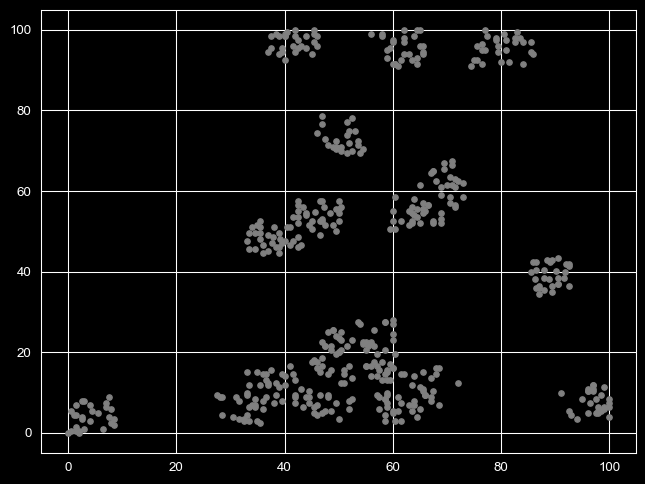

In [14]:
dataset_file_path = 'Profumi/Profumi.txt'
data = np.loadtxt(dataset_file_path)

print('Shape del dataset:', data.shape)

plt.figure(num=0, dpi=96, figsize=(8, 6))
plt.scatter(data[:,0], data[:,1], c='gray', marker='o', s=16)
plt.show()

## Esercizio

Stimare il numero di profumi analizzati utilizzando l’algoritmo *K-means*. 

Si completi il codice riportato nella cella seguente al fine di eseguire l’algoritmo *K-means* per i diversi valori del numero di cluster ($s$) nell’intervallo \[*s_min*, *s_max*\]. Per evitare che il risultato ottenuto possa essere condizionato da una scelta errata dei centroidi iniziali, consigliamo di eseguire l'algoritmo più volte (*execution_count*) per ogni valore di $s$. Al fine di evitare di ottenere risultati identici, a ogni esecuzione è necessario partire da un insieme di centroidi iniziali differente. Pertanto, il codice genera una matrice di seed diversi (*seeds*) da utilizzare nelle diverse esecuzioni di *K-means*.

Al termine dell’intera esecuzione viene mostrato il grafico del valore minimo di $J_e$ (su *execution_count* esecuzioni per ogni $s$) al variare di $s$. Al fine di rendere possibile la visualizzazione di questi valori è necessario memorizzare nella variabile $y$ il valore minimo di $J_e$ trovato per ogni $s$ (su tutte le esecuzioni - *execution_count*).

Dovendo eseguire il *K-means* un elevato numero di volte, sottenutai consiglia di utilizzare la versione di Scikit-learn perchè più efficiente rispetto alla versione appena implementata. La classe [**KMeans**](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) mette a disposizione gli attributi **inertia\_** e **n\_iter\_** che restituiscono rispettivamente il valore $J_e$ della soluzione ottenuta e il numero di iterazioni eseguite.

Nota: per questi esperimenti, considerato che l'esecuzione ripetuta di KMeans è già controllata dal ciclo su *execution_count*, è conveniente passare a *KMeans* il parametro `n_init=1` (si veda [la documentazione](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans)).

Esecuzione in corso...
Esecuzione completata.


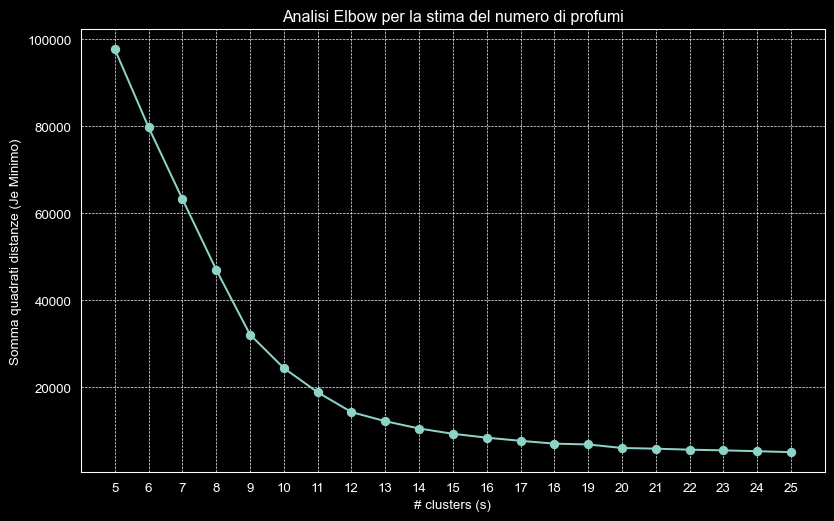

In [15]:
# Esercizio 3: si individui il numero di cluster ottimale nei
# due differenti scenari [5, 15] e [16, 25] modificando i
# successivi parametri, completando il codice e analizzando l'output
# Import necessario (se non già fatto sopra)
from sklearn.cluster import KMeans

# Parametri dell'esercizio
s_min = 5
s_max = 25  # Imposto 25 per coprire entrambi gli intervalli richiesti [5-15] e [16-25]
execution_count = 20 # Eseguiamo 20 volte per ogni s per sicurezza
initial_seed = 42
max_iteration_count = 100 # Aumentiamo leggermente per garantire convergenza

# Inizializzazione
random.seed(initial_seed)
s = np.array(range(s_min, s_max + 1))
y = np.empty(s.shape[0])

# Generazione dei seed
seeds = np.zeros((s.shape[0], execution_count), dtype=int)

for i in range(s.shape[0]):
    for j in range(execution_count):
        seeds[i, j] = random.randint(0, 1000000)

# Esecuzione iterativa di KMeans
print("Esecuzione in corso...")

for i in range(s.shape[0]):
    current_s = s[i]
    best_inertia = float('inf') # Inizializziamo con un valore infinito

    for j in range(execution_count):
        # Estraiamo il seed specifico per questa esecuzione
        current_seed = seeds[i, j]

        # Creiamo e addestriamo il modello KMeans
        # Usiamo n_init=1 perché gestiamo noi le ripetizioni col ciclo esterno
        kmeans = KMeans(n_clusters=current_s, random_state=current_seed,
                        n_init=1, max_iter=max_iteration_count)
        kmeans.fit(data)

        # Se l'inerzia (Je) è la migliore trovata finora per questo s, la salviamo
        if kmeans.inertia_ < best_inertia:
            best_inertia = kmeans.inertia_

    # Salviamo il miglior Je trovato per questo numero di cluster
    y[i] = best_inertia
    # print(f"Cluster: {current_s}, Min Inertia: {best_inertia:.2f}") # Decommenta per log

print("Esecuzione completata.")

# Plot del grafico (Elbow Method)
plt.figure(num=0, dpi=96, figsize=(10, 6)) # Aumentata leggermente la larghezza
plt.plot(s, y, marker='o')
plt.xticks(range(s_min, s_max+1))
plt.grid(True, which='both', linestyle='--', linewidth=0.5) # Aggiunta griglia per lettura facile
plt.xlabel('# clusters (s)')
plt.ylabel('Somma quadrati distanze (Je Minimo)')
plt.title('Analisi Elbow per la stima del numero di profumi')
plt.show()

Si individui il numero di profumi presenti nel dataset analizzando il grafico. Si faccia attenzione al fatto che, per come è definito $J_e$, valori grandi di $s$ producono più facilmente valori piccoli di $J_e$.

Pertanto per determinare il numero ottimale di cluster (validation) si suggerisce di:

- analizzare il grafico alla ricerca di punti di discontinuità (*elbow*);
- utilizzare *silhouette analysis* (*silhouette score* e *diagram*) presenti in Scikit-learn. Vedi:
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py


Il codice seguente può essere utilizzato come ulteriore supporto per l'individuazione dell'esatto numero di profumi analizzando visivamente le singole soluzioni ottenute al passo precedente.

/Users/samueleferri/Documents/Università/Magistrale/Machine Learning/Lab/MachineLearning/6 - KMeans/ml_visualization.py:119: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  plt.scatter(patterns[:, 0], patterns[:, 1],s=patternSize, c = patternColor,marker=marker, facecolor = '#000000')


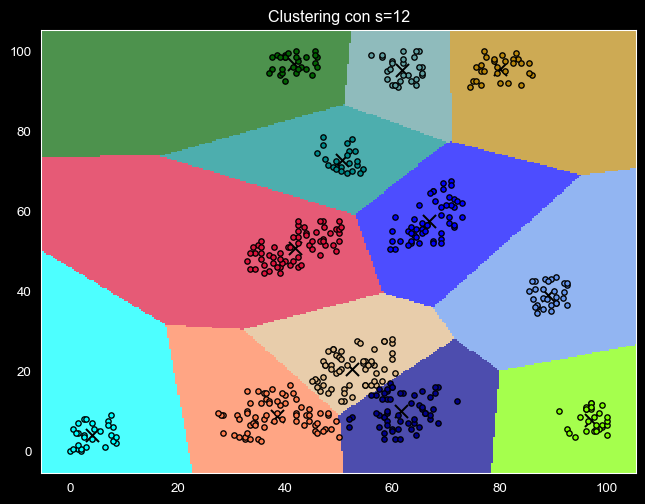

In [16]:
s = 12
seed = 42

kmeans = KMeans(n_clusters=s, random_state=seed, n_init=1)
kmeans.fit(data)

plt.figure(num=0, dpi=96, figsize=(8, 6))
ml_visualization.draw_clustering_decision_boundaries(data, kmeans.labels_, kmeans.cluster_centers_, step=0.4)
plt.title(f'Clustering con s={s}')
plt.show()

In particolare, riportare il numero reale di profumi nel caso in cui $s$ sia compreso tra 5 e 15 e nel caso in cui sia compreso tra 16 e 25.

Memorizzare i due valori di $s$ in un file di testo dal nome "Es6Predictions.txt" (un valore per riga). La cella seguente genera, date le stime di $s_1 \in [5, 15]$ e $s_2 \in [16, 25]$, il file di testo correttamente formattato.

In [ ]:
# Assegnare a s_1 e s_2 i valori trovati 
s_1 = 12
s_2 = 22

# Creazione del file di testo
result_path = 'Es6Predictions.txt'
s_values = np.array([s_1, s_2], dtype=int)
np.savetxt(result_path, s_values, fmt='%i')
print('Ok')